# JET Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the JET ensemble, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the BESS-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from ECOv003_L3T_L4T_JET import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

Set configuration options for the notebook, including whether to save plots to files.

In [2]:
# Configuration: Set to True to save plots to files, False to only display them
SAVE_PLOTS = False

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [4]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [5]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [6]:
input_df = load_ECOv002_calval_JET_inputs()

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [7]:
processed = forward_process(input_df)
processed

[2026-01-30 10:12:29 INFO] starting JET table processing
[2026-01-30 10:12:29 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:29 INFO] completed extracting geometry from JET input table (0.003 seconds)
[2026-01-30 10:12:29 INFO] started extracting time from JET input table
[2026-01-30 10:12:29 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 10:12:29 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 10:12:29 INFO] completed processing FLiES-ANN in 0.15 seconds
[2026-01-30 10:12:29 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:29 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:12:29 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 10:12:29 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 10:1

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,G_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,2.783062,24.219544,24.219544,203.764376,2.905500,0.511771,0.000151,0.000058,2.606544,
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,2.758332,13.772918,13.772918,163.144743,2.865325,1.089437,0.000108,0.000034,3.174119,
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,4.112568,33.327163,33.327163,342.564950,4.441287,0.971818,0.000291,0.000122,2.390822,
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,4.424792,42.878466,42.878466,403.011097,4.947307,1.401775,0.000294,0.000211,1.388074,
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,3.891152,2.903704,2.903704,112.556227,3.004434,0.733359,0.000095,0.000015,6.238327,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,3.535094,29.623891,29.623891,397.732265,3.642505,1.045928,0.000233,0.000137,1.697664,
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,3.145096,21.577865,21.577865,285.469147,2.876258,1.138785,0.000138,0.000101,1.357232,
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.695547,77.061858,77.061858,105.892165,1.323042,1.129719,0.000053,0.000016,3.203371,
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.743516,69.968594,69.968594,119.836612,1.411450,1.292735,0.000048,0.000031,1.555148,


## Accuracy Comparison of In-Situ Observations to Model Estimates

Examining the accuracy of model estimates compared to ground data.

analyzing JET accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


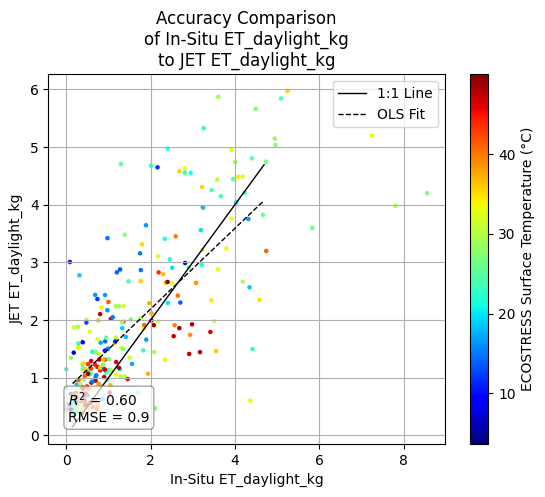

analyzing JET accuracy for G_Wm2 compared to insitu_G_Wm2


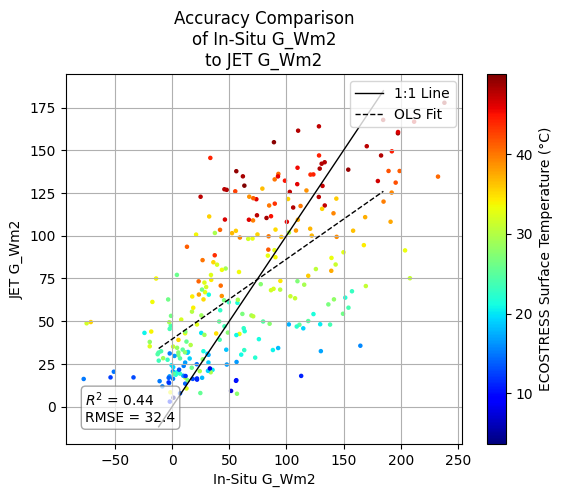

analyzing JET accuracy for H_Wm2 compared to insitu_H_Wm2


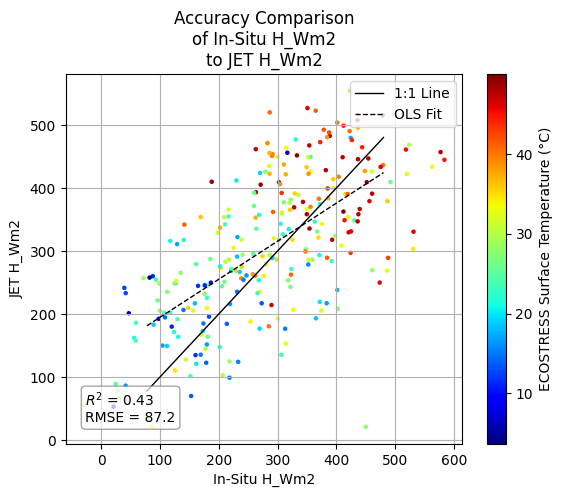

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


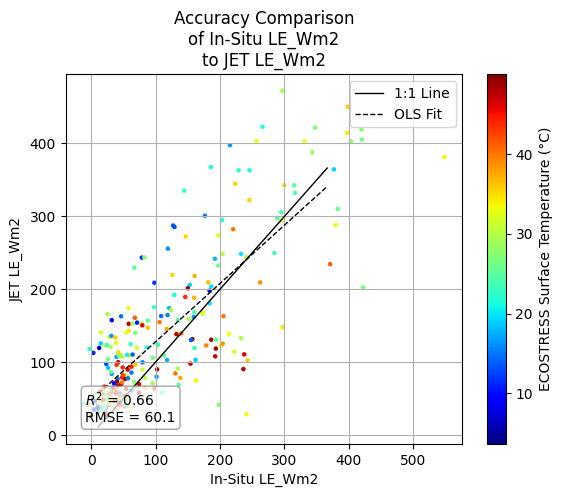

analyzing JET accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2
Error processing LE_daylight_Wm2: "['LE_daylight_Wm2'] not in index"
analyzing JET accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


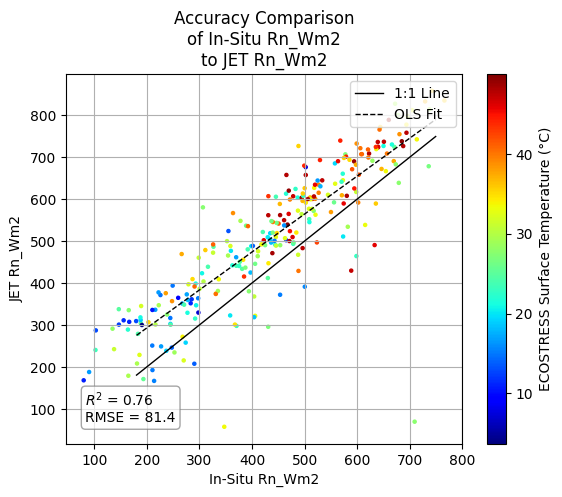

analyzing JET accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2
Error processing Rn_daylight_Wm2: "['Rn_daylight_Wm2'] not in index"
analyzing JET accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


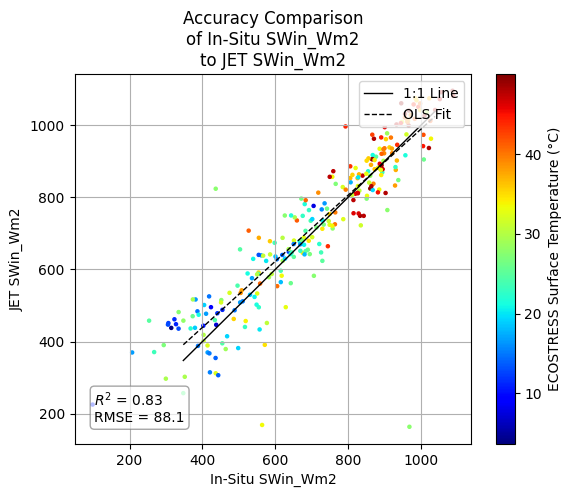

In [8]:
insitu_columns = sorted([column for column in processed.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    try:
        output_variable = insitu_variable.replace("insitu_", "")
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {output_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue

# Accuracy Comparison for Net Radiation between BESS and Verma

analyzing JET accuracy for Rn_BESS_Wm2 compared to insitu_Rn_Wm2


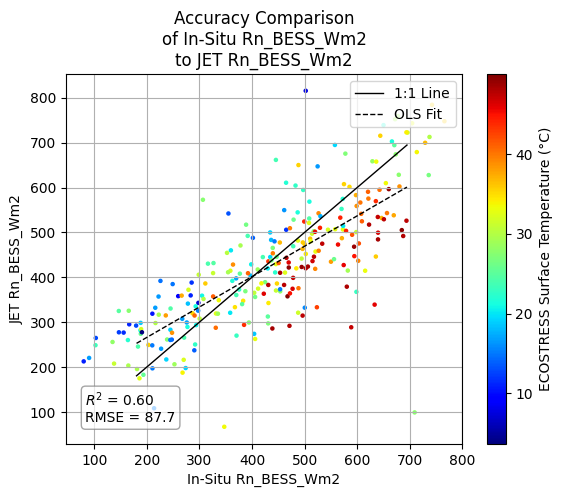

analyzing JET accuracy for Rn_verma_Wm2 compared to insitu_Rn_Wm2


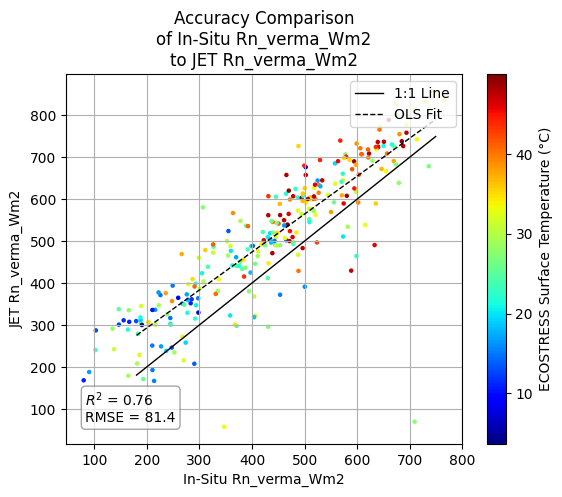

In [9]:
insitu_variable = "insitu_Rn_Wm2"

for output_variable in ["Rn_BESS_Wm2", "Rn_verma_Wm2"]:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {output_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue

analyzing JET accuracy for LE_BESS_Wm2 compared to insitu_LE_Wm2


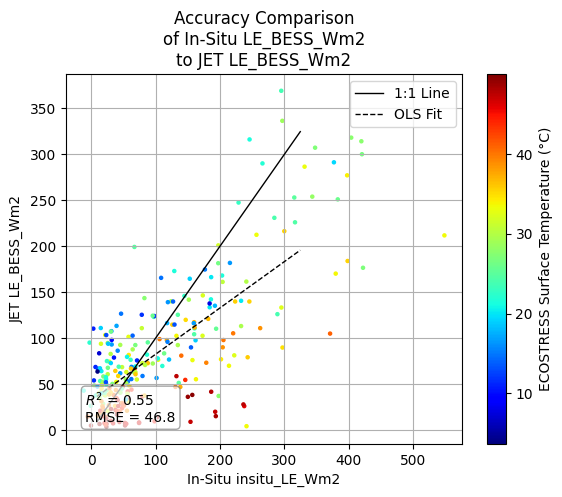

analyzing JET accuracy for LE_STIC_Wm2 compared to insitu_LE_Wm2


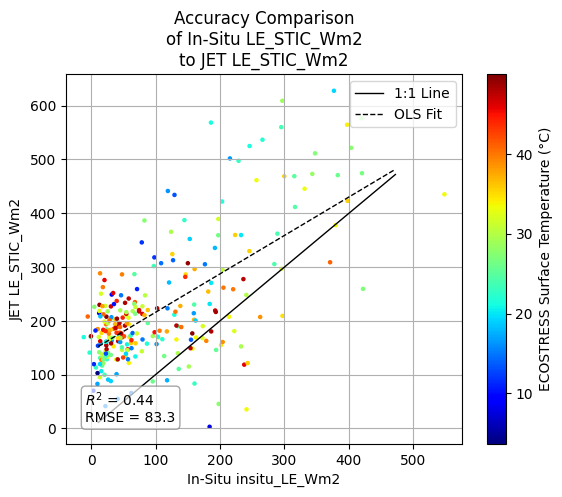

analyzing JET accuracy for LE_PTJPLSM_Wm2 compared to insitu_LE_Wm2


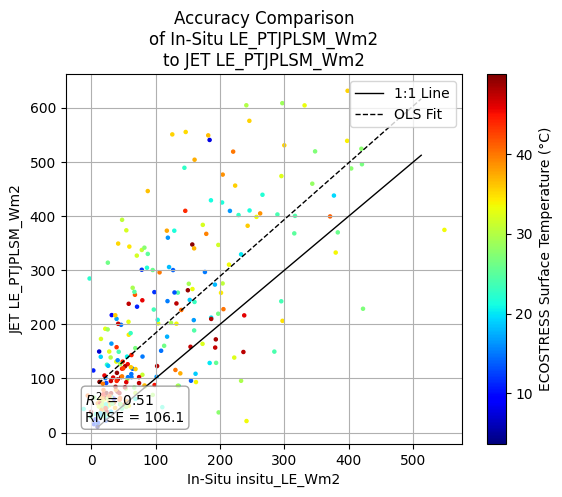

analyzing JET accuracy for LE_PMJPL_Wm2 compared to insitu_LE_Wm2


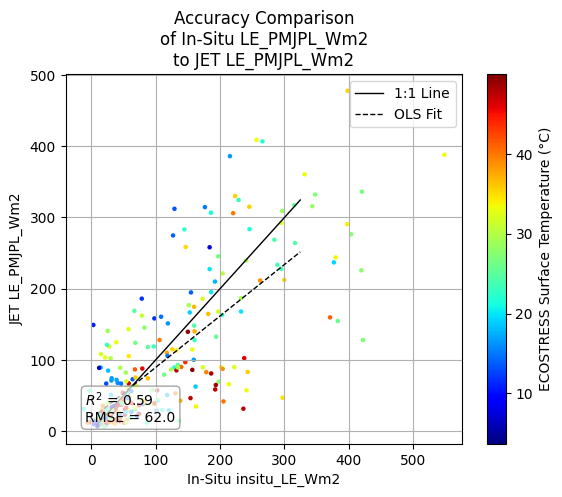

analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2


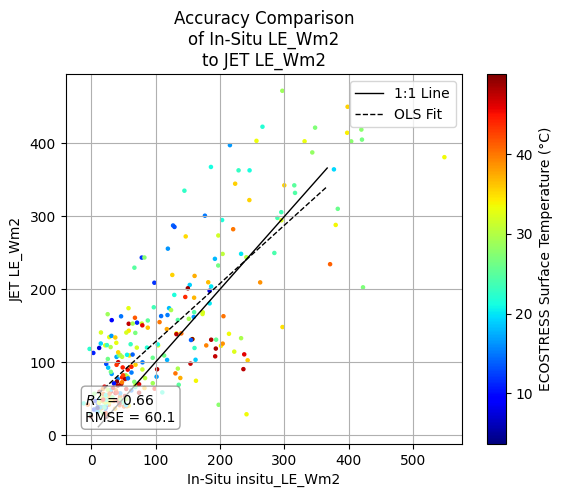

In [10]:
insitu_variable = "insitu_LE_Wm2"

output_variables = [
    "LE_BESS_Wm2",
    "LE_STIC_Wm2",
    "LE_PTJPLSM_Wm2",
    "LE_PMJPL_Wm2",
    "LE_Wm2"
]

for output_variable in output_variables:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {insitu_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {output_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        if SAVE_PLOTS:
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.jpeg", format='jpeg', bbox_inches='tight')
            plt.savefig(f"Accuracy Comparison of In-Situ {output_variable} to {model_name} {output_variable}.svg", format='svg', bbox_inches='tight')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue


## Plot Unperturbed Comparison of Surface Temperature to Net Radiation

This cell creates a scatter plot comparing ECOSTRESS surface temperature to net radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

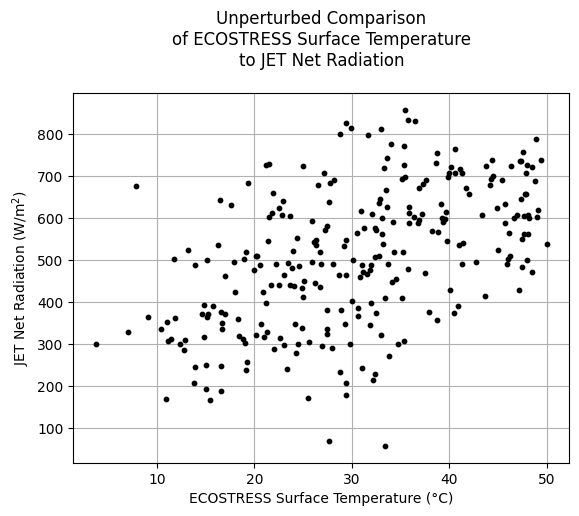

In [11]:
plt.scatter(x=processed.ST_C, y=processed.Rn_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Net Radiation (W/m$^2$)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Net Radiation", pad=20)

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Evapotranspiration

This cell creates a scatter plot comparing ECOSTRESS surface temperature to BESS-JPL evapotranspiration for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

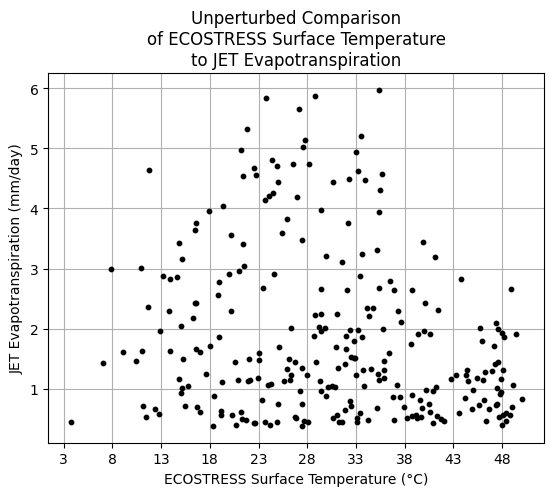

In [12]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET_daylight_kg, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Evapotranspiration (mm/day)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Evapotranspiration")

if SAVE_PLOTS:
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [13]:
len(input_df)

270

## Perturbed Model Analysis for Net Radiation

In [14]:
input_variable = "ST_C"
output_variable = "Rn_Wm2"

Rn_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_JET_table,
    normalization_function=normalization_function
)

Rn_results

[2026-01-30 10:12:31 INFO] Starting Monte Carlo perturbed run
[2026-01-30 10:12:31 INFO] calculating standard deviation of input variable: ST_C
[2026-01-30 10:12:31 INFO] input variable ST_C standard deviation: 10.766741663428048
[2026-01-30 10:12:31 INFO] starting forward process
[2026-01-30 10:12:31 INFO] starting JET table processing
[2026-01-30 10:12:31 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:31 INFO] completed extracting geometry from JET input table (0.005 seconds)
[2026-01-30 10:12:31 INFO] started extracting time from JET input table
[2026-01-30 10:12:31 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 10:12:31 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 10:12:31 INFO] completed processing FLiES-ANN in 0.11 seconds
[2026-01-30 10:12:31 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable NIR_albedo 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:31 INFO] variable APAR_sunlit_μmolm2s1 min: 94.554 mean: 334.438 max: 816.116 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable APAR_shade_μmolm2s1 min: 4.019 mean: 29.905 max: 163.617 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable ASW_sunlit_Wm2 min: 41.082 mean: 173.889 max: 328.660 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable ASW_shade_Wm2 min: 1.524 mean: 12.294 max: 74.405 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable ASW_soil_Wm2 min: 102.391 mean: 453.340 max: 736.557 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable G_Wm2 min: 10.963 mean: 60.398 max: 99.122 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable GPP_C3 min: 0.051 mean: 6.301 max: 34.198 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable LE_C3 min: 3.656 mean: 85.030 max: 368.944 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable LE_soil_C3 min: 2.517 mean: 42.377 max: 175.729 nan: 0.00% (nan)
[2026-01-30 10:12:31 INFO] variable LE_canopy_C3 min: 0.000 mean: 42.653 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

[2026-01-30 10:12:31 INFO] starting input perturbation generation
[2026-01-30 10:12:31 INFO] input perturbation generation completed
[2026-01-30 10:12:31 INFO] generating control group
[2026-01-30 10:12:31 INFO] normalizing input perturbations
[2026-01-30 10:12:31 INFO] applying perturbations
[2026-01-30 10:12:31 INFO] starting forward process for perturbed input
[2026-01-30 10:12:31 INFO] starting JET table processing
[2026-01-30 10:12:31 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:32 INFO] completed extracting geometry from JET input table (0.251 seconds)
[2026-01-30 10:12:32 INFO] started extracting time from JET input table
[2026-01-30 10:12:32 INFO] completed extracting time from JET input table (0.013 seconds)
[2026-01-30 10:12:32 INFO] running Forest Light Environmental Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
[2026-01-30 10:12:33 INFO] completed processing FLiES-ANN in 1.50 seconds
[2026-01-30 10:12:33 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:33 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:12:33 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 10:12:33 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 10:12:33 INFO] running Breathing Earth System Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


<class 'numpy.ndarray'>
float32
[2026-01-30 10:12:34 INFO] variable SZA_deg min: 17.642 mean: 46.017 max: 72.208 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable CI min: 0.188 mean: 0.266 max: 0.298 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable elevation_m min: 7.300 mean: 1164.656 max: 3504.000 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable NDVI_minimum min: -0.017 mean: 0.172 max: 0.569 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable NDVI_maximum min: 0.314 mean: 0.585 max: 0.918 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable C4_fraction min: 0.000 mean: 0.268 max: 0.939 nan: 0.00% (nan)
[2026-01-30 10:12:34 INFO] variable carbon_uptake_efficiency (float64) with [0.08       0.08133262 0.08276227 0.08521522 0.08942724 0.09
 0.09      ] unique values
[2026-01-30 10:12:34 INFO] * 0.0799999982118606: 10700
[2026-01-30 10:12:34 INFO] * 0.0813326167352959: 3200
[2026-01-30 10:12:34 INFO] * 0.0827622704609846: 200
[2026-01-30 10:12:34 INFO] * 0.0852152226652387: 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:35 INFO] calculating solar day of year
[2026-01-30 10:12:35 INFO] calculating solar hour of day
[2026-01-30 10:12:35 INFO] calculating daylight hours and sunrise hour
[2026-01-30 10:12:35 INFO] variable LE_BESS_Wm2 min: 0.000 mean: 85.135 max: 637.427 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] variable GPP_inst_umol_m2_s min: 0.000 mean: 5.550 max: 40.130 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] starting Verma net radiation processing
[2026-01-30 10:12:35 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max: 298.413 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] variable SWnet_Wm2 min: 149.392 mean: 637.467 max: 1000.028 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] variable LWin_Wm2 min: 227.974 mean: 339.497 max: 440.770 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] variable LWout_Wm2 min: 216.534 mean: 472.917 max: 913.348 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] variable Rn_Wm2 min: 0.000 mean: 504.102 max: 1016.753 nan: 0.00% (nan)
[2026-01-30 10:12:35 INFO] Verm

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:36 INFO] variable Ms min: 0.000 mean: 0.168 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:36 INFO] running STIC iteration 1 / 3
[2026-01-30 10:12:36 INFO] using variable Priestley-Taylor alpha with mean: 1.567
[2026-01-30 10:12:36 INFO] completed STIC iteration 1 / 3 with max LE change: 1775.877 (0.004655458003981039 seconds)
[2026-01-30 10:12:36 INFO] variable SM_1 min: 0.000 mean: 0.110 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:36 INFO] variable G_1 min: 0.000 mean: 66.421 max: 200.887 nan: 0.00% (nan)
[2026-01-30 10:12:36 INFO] variable LE_1 min: 0.000 mean: 191.683 max: 948.466 nan: 0.00% (nan)
[2026-01-30 10:12:36 INFO] running STIC iteration 2 / 3
[2026-01-30 10:12:36 INFO] using variable Priestley-Taylor alpha with mean: 3.676
[2026-01-30 10:12:36 INFO] completed STIC iteration 2 / 3 with max LE change: 106.358 (0.013627833002828993 seconds)
[2026-01-30 10:12:36 INFO] variable SM_2 min: 0.000 mean: 0.112 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:36 INFO

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:37 INFO] completed daylight ET upscaling (elapsed: 0.83 seconds)
[2026-01-30 10:12:37 INFO] PT-JPL-SM model run complete (elapsed: 0.87 seconds)
[2026-01-30 10:12:37 INFO] completed processing PT-JPL-SM in 0.87 seconds
[2026-01-30 10:12:37 INFO] variable LE_PTJPLSM_Wm2 min: 0.000 mean: 191.014 max: 839.078 nan: 0.00% (nan)
[2026-01-30 10:12:37 INFO] variable ET_daylight_PTJPLSM_kg min: 0.000 mean: 2.608 max: 10.267 nan: 0.00% (nan)
[2026-01-30 10:12:37 INFO] variable G_PTJPLSM min: 0.000 mean: 66.421 max: 200.887 nan: 0.00% (nan)
[2026-01-30 10:12:37 INFO] variable EF_PTJPLSM min: 0.000 mean: 0.418 max: 0.964 nan: 0.00% (nan)
[2026-01-30 10:12:37 INFO] variable LE_canopy_PTJPLSM_Wm2 min: 0.000 mean: 127.756 max: 613.118 nan: 0.00% (nan)
[2026-01-30 10:12:37 INFO] variable LE_canopy_fraction_PTJPLSM min: 0.097 mean: 0.747 max: 0.978 nan: 0.13% (nan)
[2026-01-30 10:12:37 INFO] variable LE_soil_PTJPLSM_Wm2 min: 0.000 mean: 55.791 max: 524.147 nan: 0.00% (nan)
[2026-01-30

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:38 INFO] completed daylight ET upscaling (PMJPL)
[2026-01-30 10:12:38 INFO] completed processing PM-JPL in 0.90 seconds
[2026-01-30 10:12:38 INFO] variable LE_PMJPL_Wm2 min: 0.000 mean: 94.158 max: 537.775 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable ET_daylight_PMJPL_kg min: 0.000 mean: 1.320 max: 6.711 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable G_PMJPL_Wm2 min: 0.000 mean: 66.421 max: 200.887 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable ET_daylight_kg min: 0.000 mean: 1.736 max: 7.923 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] JET table processing complete (7.043 seconds)
[2026-01-30 10:12:38 INFO] completed forward process for perturbed input
[2026-01-30 10:12:38 INFO] normalizing output perturbations
[2026-01-30 10:12:38 INFO] Monte Carlo run complete


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,Rn_Wm2,20.01,4.912963,0.245525,24.922963,476.697616,-27.983164,0.058702,448.714452
1,ST_C,Rn_Wm2,20.01,-11.530713,0.576248,8.479287,476.697616,60.36766,0.126637,537.065275
2,ST_C,Rn_Wm2,20.01,3.269646,0.163401,23.279646,476.697616,-18.467625,0.038741,458.229990
3,ST_C,Rn_Wm2,20.01,-10.589755,0.529223,9.420245,476.697616,55.710544,0.116868,532.408159
4,ST_C,Rn_Wm2,20.01,-0.925443,0.046249,19.084557,476.697616,5.116162,0.010733,481.813777
...,...,...,...,...,...,...,...,...,...,...
26995,ST_C,Rn_Wm2,35.23,-12.838937,0.364432,22.391063,519.082396,76.363171,0.147112,595.445567
26996,ST_C,Rn_Wm2,35.23,2.477889,0.070335,37.707889,519.082396,-15.881059,0.030594,503.201337
26997,ST_C,Rn_Wm2,35.23,18.839819,0.534766,54.069819,519.082396,-130.685544,0.251763,388.396852
26998,ST_C,Rn_Wm2,35.23,-7.614194,0.216128,27.615806,519.082396,46.459413,0.089503,565.541809


## Perturbed Model Analysis for Evapotranspiration

In [15]:
input_variable = "ST_C"
output_variable = "ET_daylight_kg"

ET_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=forward_process,
    normalization_function=normalization_function
)

ET_results = ET_results.dropna()

ET_results

[2026-01-30 10:12:38 INFO] Starting Monte Carlo perturbed run
[2026-01-30 10:12:38 INFO] calculating standard deviation of input variable: ST_C
[2026-01-30 10:12:38 INFO] input variable ST_C standard deviation: 10.766741663428048
[2026-01-30 10:12:38 INFO] starting forward process
[2026-01-30 10:12:38 INFO] starting JET table processing
[2026-01-30 10:12:38 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:38 INFO] completed extracting geometry from JET input table (0.004 seconds)
[2026-01-30 10:12:38 INFO] started extracting time from JET input table
[2026-01-30 10:12:38 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 10:12:38 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 10:12:38 INFO] completed processing FLiES-ANN in 0.12 seconds
[2026-01-30 10:12:38 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable NIR_albedo 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:38 INFO] calculating solar day of year
[2026-01-30 10:12:38 INFO] calculating solar hour of day
[2026-01-30 10:12:38 INFO] calculating daylight hours and sunrise hour
[2026-01-30 10:12:38 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable GPP_inst_umol_m2_s min: 0.006 mean: 6.632 max: 39.888 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] starting Verma net radiation processing
[2026-01-30 10:12:38 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max: 298.413 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable SWnet_Wm2 min: 149.392 mean: 637.467 max: 1000.028 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable LWin_Wm2 min: 227.974 mean: 339.497 max: 440.770 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable LWout_Wm2 min: 316.593 mean: 469.764 max: 596.879 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] variable Rn_Wm2 min: 57.448 mean: 507.201 max: 858.158 nan: 0.00% (nan)
[2026-01-30 10:12:38 INFO] Verm

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

[2026-01-30 10:12:39 INFO] starting input perturbation generation
[2026-01-30 10:12:39 INFO] input perturbation generation completed
[2026-01-30 10:12:39 INFO] generating control group
[2026-01-30 10:12:39 INFO] normalizing input perturbations
[2026-01-30 10:12:39 INFO] applying perturbations
[2026-01-30 10:12:39 INFO] starting forward process for perturbed input
[2026-01-30 10:12:39 INFO] starting JET table processing
[2026-01-30 10:12:39 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:39 INFO] completed extracting geometry from JET input table (0.348 seconds)
[2026-01-30 10:12:39 INFO] started extracting time from JET input table
[2026-01-30 10:12:39 INFO] completed extracting time from JET input table (0.013 seconds)
[2026-01-30 10:12:39 INFO] running Forest Light Environmental Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
[2026-01-30 10:12:41 INFO] completed processing FLiES-ANN in 1.49 seconds
[2026-01-30 10:12:41 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] running Breathing Earth System Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


<class 'numpy.ndarray'>
float32
[2026-01-30 10:12:41 INFO] variable SZA_deg min: 17.642 mean: 46.017 max: 72.208 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable CI min: 0.188 mean: 0.266 max: 0.298 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable elevation_m min: 7.300 mean: 1164.656 max: 3504.000 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable NDVI_minimum min: -0.017 mean: 0.172 max: 0.569 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable NDVI_maximum min: 0.314 mean: 0.585 max: 0.918 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable C4_fraction min: 0.000 mean: 0.268 max: 0.939 nan: 0.00% (nan)
[2026-01-30 10:12:41 INFO] variable carbon_uptake_efficiency (float64) with [0.08       0.08133262 0.08276227 0.08521522 0.08942724 0.09
 0.09      ] unique values
[2026-01-30 10:12:41 INFO] * 0.0799999982118606: 10700
[2026-01-30 10:12:41 INFO] * 0.0813326167352959: 3200
[2026-01-30 10:12:41 INFO] * 0.0827622704609846: 200
[2026-01-30 10:12:41 INFO] * 0.0852152226652387: 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:43 INFO] calculating solar day of year
[2026-01-30 10:12:43 INFO] calculating solar hour of day
[2026-01-30 10:12:43 INFO] calculating daylight hours and sunrise hour
[2026-01-30 10:12:43 INFO] variable LE_BESS_Wm2 min: 0.000 mean: 85.185 max: 673.958 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable GPP_inst_umol_m2_s min: 0.000 mean: 5.520 max: 40.130 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] starting Verma net radiation processing
[2026-01-30 10:12:43 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max: 298.413 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable SWnet_Wm2 min: 149.392 mean: 637.467 max: 1000.028 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable LWin_Wm2 min: 227.974 mean: 339.497 max: 440.770 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable LWout_Wm2 min: 198.939 mean: 472.990 max: 888.438 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable Rn_Wm2 min: 0.000 mean: 504.025 max: 994.677 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] Verma

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:43 INFO] variable Ms min: 0.000 mean: 0.167 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] running STIC iteration 1 / 3
[2026-01-30 10:12:43 INFO] using variable Priestley-Taylor alpha with mean: 1.571
[2026-01-30 10:12:43 INFO] completed STIC iteration 1 / 3 with max LE change: 1734.488 (0.004711624998890329 seconds)
[2026-01-30 10:12:43 INFO] variable SM_1 min: 0.000 mean: 0.110 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable G_1 min: 0.000 mean: 66.425 max: 199.676 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] variable LE_1 min: 0.000 mean: 191.258 max: 961.788 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO] running STIC iteration 2 / 3
[2026-01-30 10:12:43 INFO] using variable Priestley-Taylor alpha with mean: 3.737
[2026-01-30 10:12:43 INFO] completed STIC iteration 2 / 3 with max LE change: 106.499 (0.01340070799778914 seconds)
[2026-01-30 10:12:43 INFO] variable SM_2 min: 0.000 mean: 0.112 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:12:43 INFO]

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:45 INFO] completed daylight ET upscaling (elapsed: 0.81 seconds)
[2026-01-30 10:12:45 INFO] PT-JPL-SM model run complete (elapsed: 0.84 seconds)
[2026-01-30 10:12:45 INFO] completed processing PT-JPL-SM in 0.84 seconds
[2026-01-30 10:12:45 INFO] variable LE_PTJPLSM_Wm2 min: 0.000 mean: 191.029 max: 836.644 nan: 0.00% (nan)
[2026-01-30 10:12:45 INFO] variable ET_daylight_PTJPLSM_kg min: 0.000 mean: 2.608 max: 10.287 nan: 0.00% (nan)
[2026-01-30 10:12:45 INFO] variable G_PTJPLSM min: 0.000 mean: 66.425 max: 199.676 nan: 0.00% (nan)
[2026-01-30 10:12:45 INFO] variable EF_PTJPLSM min: 0.000 mean: 0.418 max: 0.964 nan: 0.00% (nan)
[2026-01-30 10:12:45 INFO] variable LE_canopy_PTJPLSM_Wm2 min: 0.000 mean: 127.717 max: 626.281 nan: 0.00% (nan)
[2026-01-30 10:12:45 INFO] variable LE_canopy_fraction_PTJPLSM min: 0.097 mean: 0.747 max: 0.979 nan: 0.13% (nan)
[2026-01-30 10:12:45 INFO] variable LE_soil_PTJPLSM_Wm2 min: 0.000 mean: 55.826 max: 544.778 nan: 0.00% (nan)
[2026-01-30

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:46 INFO] completed daylight ET upscaling (PMJPL)
[2026-01-30 10:12:46 INFO] completed processing PM-JPL in 0.90 seconds
[2026-01-30 10:12:46 INFO] variable LE_PMJPL_Wm2 min: 0.000 mean: 94.241 max: 528.387 nan: 0.00% (nan)
[2026-01-30 10:12:46 INFO] variable ET_daylight_PMJPL_kg min: 0.000 mean: 1.322 max: 7.236 nan: 0.00% (nan)
[2026-01-30 10:12:46 INFO] variable G_PMJPL_Wm2 min: 0.000 mean: 66.425 max: 199.676 nan: 0.00% (nan)
[2026-01-30 10:12:46 INFO] variable ET_daylight_kg min: 0.000 mean: 1.736 max: 7.947 nan: 0.00% (nan)
[2026-01-30 10:12:46 INFO] JET table processing complete (7.074 seconds)
[2026-01-30 10:12:46 INFO] completed forward process for perturbed input
[2026-01-30 10:12:46 INFO] normalizing output perturbations
[2026-01-30 10:12:46 INFO] Monte Carlo run complete


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,ET_daylight_kg,20.01,-11.509852,0.575205,8.500148,2.9055,-0.019133,0.006585,2.886367
1,ST_C,ET_daylight_kg,20.01,16.533544,0.826264,36.543544,2.9055,-1.17658,0.404949,1.728920
2,ST_C,ET_daylight_kg,20.01,-2.550707,0.127472,17.459293,2.9055,0.0633,0.021786,2.968800
3,ST_C,ET_daylight_kg,20.01,1.459496,0.072938,21.469496,2.9055,-0.068989,0.023744,2.836511
4,ST_C,ET_daylight_kg,20.01,9.220814,0.460810,29.230814,2.9055,-0.543054,0.186906,2.362446
...,...,...,...,...,...,...,...,...,...,...
26995,ST_C,ET_daylight_kg,35.23,7.020872,0.199287,42.250872,1.242322,-0.474795,0.382184,0.767527
26996,ST_C,ET_daylight_kg,35.23,7.775792,0.220715,43.005792,1.242322,-0.503956,0.405656,0.738366
26997,ST_C,ET_daylight_kg,35.23,-5.545205,0.157400,29.684795,1.242322,0.433232,0.348728,1.675555
26998,ST_C,ET_daylight_kg,35.23,10.443241,0.296430,45.673241,1.242322,-0.592196,0.476684,0.650127


## Plot Change in Surface Temperature vs Net Radiation

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in BESS-JPL net radiation due to input perturbations. The plot is saved as JPEG and SVG files.

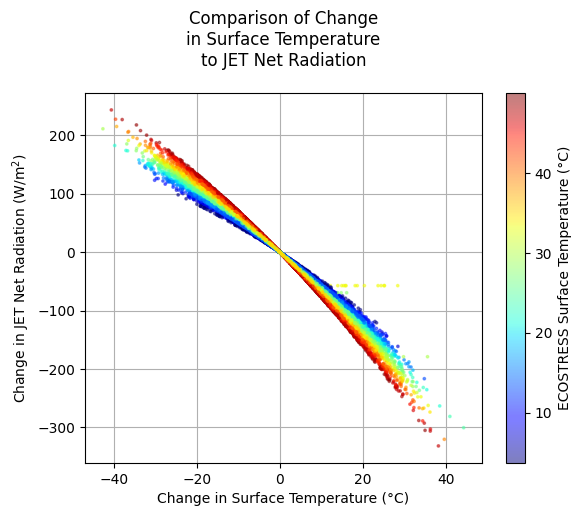

In [16]:
sc = plt.scatter(
    x=Rn_results.input_perturbation, 
    y=Rn_results.output_perturbation, 
    c=Rn_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Net Radiation (W/m$^2$)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Net Radiation", pad=20)
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")

if SAVE_PLOTS:
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Change in Surface Temperature vs Evapotranspiration

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in evapotranspiration due to input perturbations. The plot is saved as JPEG and SVG files.

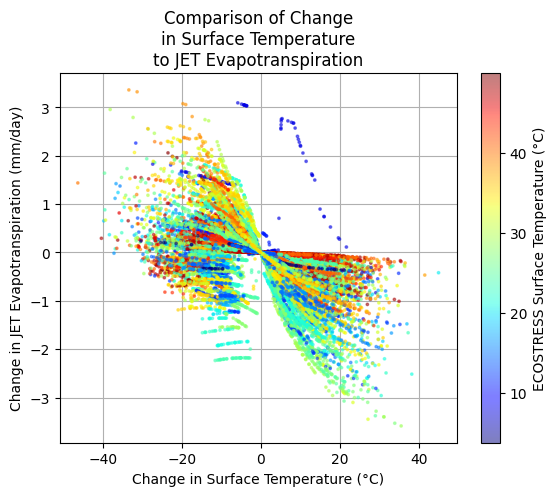

In [17]:
sc = plt.scatter(
    x=ET_results.input_perturbation, 
    y=ET_results.output_perturbation, 
    c=ET_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Evapotranspiration (mm/day)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Evapotranspiration")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")

if SAVE_PLOTS:
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
    plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [18]:
perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_JET_table,
    normalization_function=normalization_function,
    use_joint_run=True,  # Explicitly enable joint run mode
    input_min=input_min,
    input_max=input_max
 )

sensitivity_metrics_df

[2026-01-30 10:12:46 INFO] starting JET table processing
[2026-01-30 10:12:46 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:46 INFO] completed extracting geometry from JET input table (0.003 seconds)
[2026-01-30 10:12:46 INFO] started extracting time from JET input table
[2026-01-30 10:12:46 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 10:12:46 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 10:12:47 INFO] completed processing FLiES-ANN in 0.12 seconds
[2026-01-30 10:12:47 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 10:1

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:12:47 INFO] calculating solar day of year
[2026-01-30 10:12:47 INFO] calculating solar hour of day
[2026-01-30 10:12:47 INFO] calculating daylight hours and sunrise hour
[2026-01-30 10:12:47 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable GPP_inst_umol_m2_s min: 0.006 mean: 6.632 max: 39.888 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] starting Verma net radiation processing
[2026-01-30 10:12:47 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max: 298.413 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable SWnet_Wm2 min: 149.392 mean: 637.467 max: 1000.028 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable LWin_Wm2 min: 227.974 mean: 339.497 max: 440.770 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable LWout_Wm2 min: 316.593 mean: 469.764 max: 596.879 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] variable Rn_Wm2 min: 57.448 mean: 507.201 max: 858.158 nan: 0.00% (nan)
[2026-01-30 10:12:47 INFO] Verm

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

[2026-01-30 10:12:48 INFO] starting JET table processing
[2026-01-30 10:12:51 INFO] started extracting geometry from JET input table
[2026-01-30 10:12:54 INFO] completed extracting geometry from JET input table (2.834 seconds)
[2026-01-30 10:12:54 INFO] started extracting time from JET input table
[2026-01-30 10:12:54 INFO] completed extracting time from JET input table (0.263 seconds)
[2026-01-30 10:12:54 INFO] running Forest Light Environmental Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


9282/9282 ━━━━━━━━━━━━━━━━━━━━ 4s 378us/step
[2026-01-30 10:13:10 INFO] completed processing FLiES-ANN in 15.74 seconds
[2026-01-30 10:13:10 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 10:13:10 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 10:13:10 INFO] variable PAR_direct_Wm2 min: 5.852 mean: 264.175 max: 470.165 nan: 0.00% (nan)
[2026-01-30 10:13:10 INFO] variable SWin_FLiES_ANN min: 73.694 mean: 711.053 max: 1125.470 nan: 0.00% (nan)
[2026-01-30 10:13:10 INFO] running Breathing Earth System Simulator


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


<class 'numpy.ndarray'>
float32
[2026-01-30 10:13:17 INFO] variable SZA_deg min: 17.642 mean: 46.017 max: 72.208 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable CI min: 0.188 mean: 0.266 max: 0.298 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable elevation_m min: 0.000 mean: 1167.431 max: 5567.288 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable NDVI_minimum min: -0.017 mean: 0.172 max: 0.569 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable NDVI_maximum min: 0.314 mean: 0.585 max: 0.918 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable C4_fraction min: 0.000 mean: 0.268 max: 0.939 nan: 0.00% (nan)
[2026-01-30 10:13:17 INFO] variable carbon_uptake_efficiency (float64) with [0.08       0.08133262 0.08276227 0.08521522 0.08942724 0.09
 0.09      ] unique values
[2026-01-30 10:13:17 INFO] * 0.0799999982118606: 117700
[2026-01-30 10:13:17 INFO] * 0.0813326167352959: 35200
[2026-01-30 10:13:17 INFO] * 0.0827622704609846: 2200
[2026-01-30 10:13:17 INFO] * 0.085215222665238

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: divide by zero encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:76: RuntimeWarning: divide by zero encountered in divide
  rs = 1.0 / (gs1 / cf * 1e-2)  # [s m-1]
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/process_paw_and_gao_LE.py:39: RuntimeWarning: invalid value encountered in divide
  LE = (-b + np.sign(b) * np.sqrt(b * b - 4.0 * a * c)) / (2.0 * a)  # Eq. (10a)
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/BESS_JPL/canopy_energy_balance.py:70: RuntimeWarning: invalid value encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]


[2026-01-30 10:13:19 INFO] variable GPP_C4 min: 0.000 mean: 9.848 max: 50.000 nan: 1.47% (nan)
[2026-01-30 10:13:19 INFO] variable LE_C4 min: 0.000 mean: 87.029 max: 734.776 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] variable LE_soil_C4 min: 0.000 mean: 41.630 max: 318.100 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] variable LE_canopy_C4 min: 0.000 mean: 45.398 max: 699.263 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] variable Rn_C4 min: 0.000 mean: 419.812 max: 1000.000 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] variable Rn_soil_C4 min: 0.000 mean: 330.588 max: 829.824 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] variable Rn_canopy_C4 min: 0.000 mean: 89.386 max: 819.942 nan: 0.00% (nan)
[2026-01-30 10:13:19 INFO] started daylight ET upscaling
[2026-01-30 10:13:25 INFO] completed daylight ET upscaling (elapsed: 5.92 seconds)
[2026-01-30 10:13:25 INFO] completed processing BESS-JPL in 15.31 seconds
[2026-01-30 10:13:25 INFO] variable Rn_BESS_Wm2 min: 0.000 mean: 419.812 max: 1000.000 n

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:13:28 INFO] calculating solar day of year
[2026-01-30 10:13:29 INFO] calculating solar hour of day


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:13:30 INFO] calculating daylight hours and sunrise hour
[2026-01-30 10:13:30 INFO] variable LE_BESS_Wm2 min: 0.000 mean: 85.510 max: 715.152 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] variable GPP_inst_umol_m2_s min: 0.000 mean: 6.700 max: 43.149 nan: 1.47% (nan)
[2026-01-30 10:13:30 INFO] starting Verma net radiation processing
[2026-01-30 10:13:30 INFO] variable SWout_Wm2 min: 0.000 mean: 78.853 max: 434.045 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] variable SWnet_Wm2 min: 65.867 mean: 632.200 max: 1088.185 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] variable LWin_Wm2 min: 218.895 mean: 339.845 max: 644.037 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] variable LWout_Wm2 min: 292.299 mean: 469.645 max: 608.447 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] variable Rn_Wm2 min: 0.000 mean: 502.407 max: 1013.703 nan: 0.00% (nan)
[2026-01-30 10:13:30 INFO] Verma net radiation processing complete in 0.06 seconds
[2026-01-30 10:13:30 INFO] running Surface Temperature Initiate

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:13:37 INFO] variable Ms min: 0.000 mean: 0.189 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:13:37 INFO] running STIC iteration 1 / 3
[2026-01-30 10:13:37 INFO] using variable Priestley-Taylor alpha with mean: 1.255
[2026-01-30 10:13:37 INFO] completed STIC iteration 1 / 3 with max LE change: 2341.217 (0.037729916999523994 seconds)
[2026-01-30 10:13:37 INFO] variable SM_1 min: 0.000 mean: 0.105 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:13:37 INFO] variable G_1 min: 0.000 mean: 68.312 max: 222.789 nan: 1.47% (nan)
[2026-01-30 10:13:37 INFO] variable LE_1 min: 0.000 mean: 211.394 max: 941.114 nan: 1.47% (nan)
[2026-01-30 10:13:37 INFO] running STIC iteration 2 / 3
[2026-01-30 10:13:37 INFO] using variable Priestley-Taylor alpha with mean: 1.61
[2026-01-30 10:13:37 INFO] completed STIC iteration 2 / 3 with max LE change: 104.703 (0.10411216699867509 seconds)
[2026-01-30 10:13:37 INFO] variable SM_2 min: 0.000 mean: 0.111 max: 1.000 nan: 0.00% (nan)
[2026-01-30 10:13:37 INFO] 

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:13:43 INFO] variable LE_soil_Wm2 min: 0.000 mean: 55.286 max: 581.408 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable Rn_canopy_Wm2 min: 0.000 mean: 190.536 max: 893.142 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable PET min: 0.000 mean: 388.381 max: 1058.850 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable fTRM min: 0.002 mean: 0.832 max: 1.000 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable LE_canopy_Wm2 min: 0.000 mean: 129.310 max: 750.670 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable LE_interception_Wm2 min: 0.000 mean: 7.697 max: 390.504 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] variable LE_Wm2 min: 0.000 mean: 192.293 max: 875.647 nan: 1.47% (nan)
[2026-01-30 10:13:43 INFO] started daylight ET upscaling


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:13:52 INFO] completed daylight ET upscaling (elapsed: 8.91 seconds)
[2026-01-30 10:13:52 INFO] PT-JPL-SM model run complete (elapsed: 9.13 seconds)
[2026-01-30 10:13:52 INFO] completed processing PT-JPL-SM in 9.13 seconds
[2026-01-30 10:13:52 INFO] variable LE_PTJPLSM_Wm2 min: 0.000 mean: 192.293 max: 875.647 nan: 1.47% (nan)
[2026-01-30 10:13:52 INFO] variable ET_daylight_PTJPLSM_kg min: 0.000 mean: 2.637 max: 12.482 nan: 1.47% (nan)
[2026-01-30 10:13:52 INFO] variable G_PTJPLSM min: 0.000 mean: 68.312 max: 222.789 nan: 1.47% (nan)
[2026-01-30 10:13:52 INFO] variable EF_PTJPLSM min: 0.000 mean: 0.423 max: 1.146 nan: 1.47% (nan)
[2026-01-30 10:13:52 INFO] variable LE_canopy_PTJPLSM_Wm2 min: 0.000 mean: 129.310 max: 750.670 nan: 1.47% (nan)
[2026-01-30 10:13:52 INFO] variable LE_canopy_fraction_PTJPLSM min: 0.000 mean: 0.743 max: 1.000 nan: 1.49% (nan)
[2026-01-30 10:13:52 INFO] variable LE_soil_PTJPLSM_Wm2 min: 0.000 mean: 55.286 max: 581.408 nan: 1.47% (nan)
[2026-01-30

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 10:14:01 INFO] completed daylight ET upscaling (PMJPL)
[2026-01-30 10:14:01 INFO] completed processing PM-JPL in 9.29 seconds
[2026-01-30 10:14:01 INFO] variable LE_PMJPL_Wm2 min: 0.000 mean: 97.081 max: 780.303 nan: 1.47% (nan)
[2026-01-30 10:14:01 INFO] variable ET_daylight_PMJPL_kg min: 0.000 mean: 1.361 max: 9.000 nan: 1.47% (nan)
[2026-01-30 10:14:01 INFO] variable G_PMJPL_Wm2 min: 0.000 mean: 68.312 max: 222.789 nan: 1.47% (nan)
[2026-01-30 10:14:01 INFO] variable ET_daylight_kg min: 0.000 mean: 1.838 max: 8.802 nan: 0.00% (nan)
[2026-01-30 10:14:02 INFO] JET table processing complete (74.397 seconds)


,input_variable,output_variable,metric,value
0,ST_C,LE_BESS_Wm2,correlation,0.120520
1,ST_C,LE_BESS_Wm2,r2,0.014525
2,ST_C,LE_BESS_Wm2,mean_normalized_change,0.508088
3,NDVI,LE_BESS_Wm2,correlation,0.633312
4,NDVI,LE_BESS_Wm2,r2,0.401084
...,...,...,...,...
160,elevation_m,LE_Wm2,r2,0.008279
161,elevation_m,LE_Wm2,mean_normalized_change,0.029340
162,canopy_height_meters,LE_Wm2,correlation,0.103522
163,canopy_height_meters,LE_Wm2,r2,0.010717


## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input.

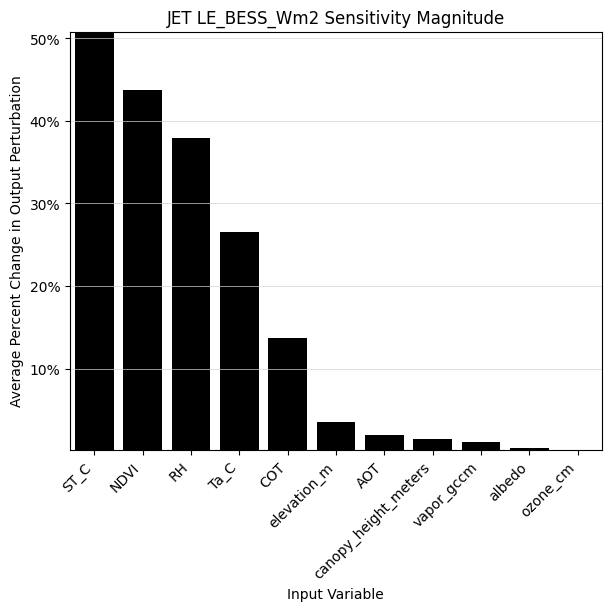

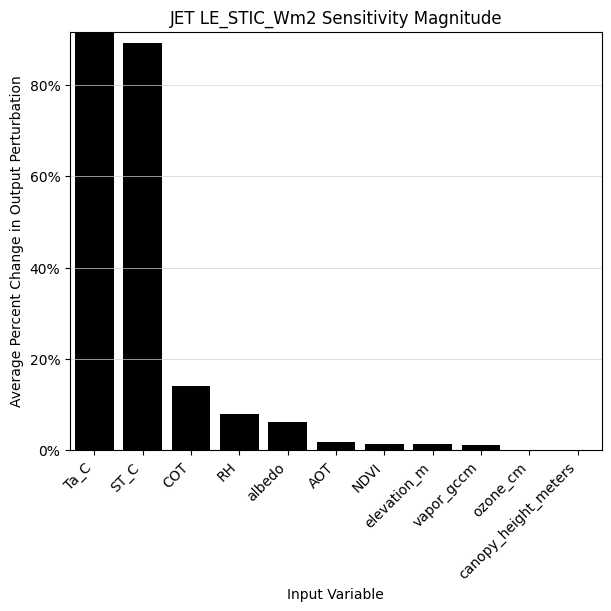

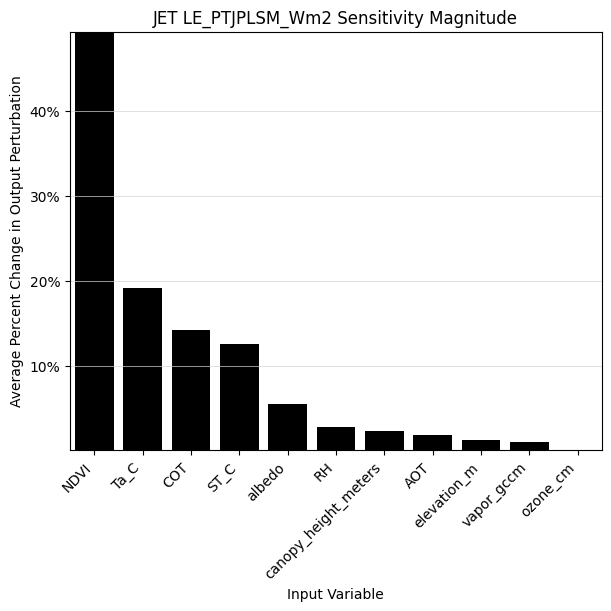

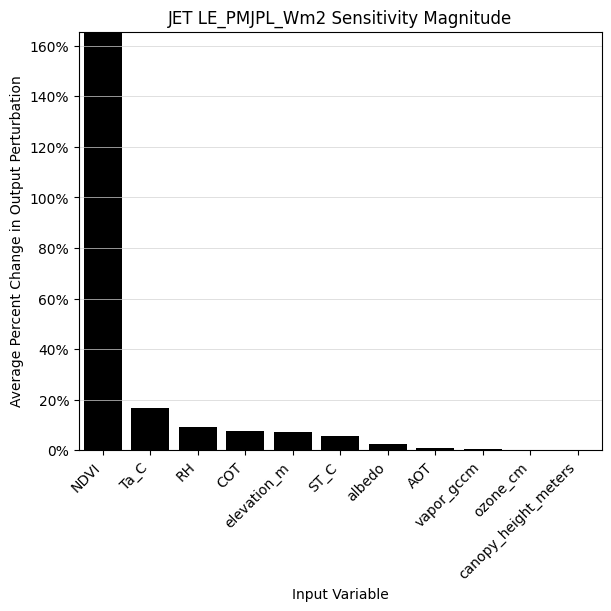

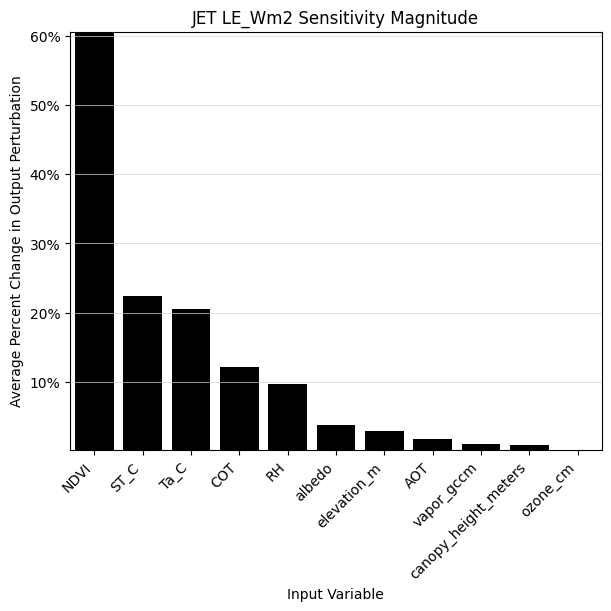

In [19]:
for output_variable in output_variables:
    sensitivity_magnitude_barchart(
        model_name=model_name,
        output_variable=output_variable,
        df=sensitivity_metrics_df
    )

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the BESS-JPL model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.